# Systems Programming: Project Report

**Important: This is a PDF export of the interative benchmark tool ran on my machine (specs below). It is portable and can run it very easily on your machine, just follow the instructions in README.md**

## Implemented Features Breakdown

### Required Features

- LIFO Scheduler, with stack implemented as a linked list

- Work Stealing Scheduler, with deque implemented as a linked list

- Benchmark results for both schedulers by number of threads, including a comparison between the two

### Additional Features

- Interactive benchmarking tool `Interactive Benchmark.ipynb` written in Python (Notebooks)  with the ability to run benchmarks for both schedulers with custom parameters and display the results in graphs (one for each scheduler, one for comparison). Running it is easy, just open the notebook, follow the instructions and run the cells. It will automatically adapt to your machine's specs and run the benchmarks.

- Beautiful fractal generation with movement and zoom using the more efficient work stealing scheduler. The fractal is generated using the Mandelbrot set algorithm. The fractal is generated in parallel using a recursive task creation algorithm (Splits width/height until below a threshold). The program is interactive, has the ability to move and zoom smoothly in the fractal. The fractal is displayed using the SDL2 library. It also contains multiple color schemes and a frame time performance benchmark. The fractal generation is implemented in the `fractal` directory. Benchmarks on my machine (specs below) :
    - Using `render_mandelbrot_parallel` function, the frame time is around 0.08s
    - Using `render_mandelbrot` function, the frame time is around 0.3s
    - Parallel version is around 4 times faster than the sequential version

- A synchronizing workstealing scheduler, which never stops running and allows for waiting for the completion of a task. It allows for the fractal (or other graphical programs) to wait for the completion of a task (rendering a frame for example) before starting the next one, using `void wait_for_threads(scheduler *s)` function. It is necessary because the old interface did not allow for that feature, and initializing a scheduler was blocking until the provided task was done. The synchronizing workstealing scheduler is implemented in the `workstealing_sched_sync.c` file.

- A Makefile with selective compilation options, compiling only the required files for the selected target. Four targets are available: `quicklifo`, `quicksteal`, `stealbench` and `fracsteal`. The `quicklifo` target compiles the LIFO scheduler and the benchmarking tool. The `quicksteal` target compiles the work stealing scheduler and the benchmarking tool. The `stealbench` target compiles the work stealing scheduler for benchmarking. The `fracsteal` target compiles the fractal generation program (uses quick stealing scheduler).

- An exponential backoff algorithm for the work stealing scheduler, which is more efficient than waiting for 1ms every time. The algorithm is implemented in both `work_stealing_sched.c` and `work_stealing_sched_sync.c` files.

- Detailed Work Stealing Scheduler benchmarks with interactive benchmarking tool extension in the bottom of the `Interactive Benchmark.ipynb` notebook. Here is what it does :
    - Benchmarking the number of successful and failed steals by the work stealing scheduler using `steal_success` and `steal_fail` counters. Each thread has it's own counters to not require sync and interfere with performance.
    - Benchmarking the number of tasks done by each thread, to check the efficiency of the scheduler. This is done by calling the logging function `log_task(int thread_id, scheduler *s)` before starting a task.
    - Display the results in a graph, showing the number of successful and failed steals by each thread, and the number of tasks done by each thread.

# Interactive Benchmark - Schedulers Performance

## Utility functions and benchmark setup

### Regex parsing function for the C "time done" output

In [19]:
import re

def parse_process_output(output):
    match = re.search(r"\d+\.\d+", output)
    if match:
        number = float(match.group())
    else:
        number = None
    return number

### Display current specs and initial config

In [34]:
import subprocess
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np

cores_count = multiprocessing.cpu_count()
print("Benchmark done on a AMD Ryzen 9 3900X 12-Core Processor with Simultaneous Multithreading (SMT) enabled")
print(f"Detected {cores_count} cores")

core_values = list(range(1, cores_count + 1))
default_n_size = 10 * 1024 * 1024

multiplier = 10
size = default_n_size * multiplier

print(f"Benchmarking with a size of {multiplier} * 10MB (default quicksort size)")

Benchmark done on a AMD Ryzen 9 3900X 12-Core Processor with Simultaneous Multithreading (SMT) enabled
Detected 24 cores
Benchmarking with a size of 10 * 10MB (default quicksort size)


## Benchmarking Quicksort + LIFO scheduler

Compiling quicklifo...
Running benchmarks for ./quicklifo -t num_cores -n 104857600
[01] Time taken: 17.509984 seconds
[02] Time taken: 9.279284 seconds
[03] Time taken: 6.436856 seconds
[04] Time taken: 5.178791 seconds
[05] Time taken: 4.433078 seconds
[06] Time taken: 4.078858 seconds
[07] Time taken: 3.851509 seconds
[08] Time taken: 3.742197 seconds
[09] Time taken: 3.819355 seconds
[10] Time taken: 3.910319 seconds
[11] Time taken: 3.97783 seconds
[12] Time taken: 3.791003 seconds
[13] Time taken: 3.855192 seconds
[14] Time taken: 3.919726 seconds
[15] Time taken: 4.140905 seconds
[16] Time taken: 4.22738 seconds
[17] Time taken: 4.230741 seconds
[18] Time taken: 4.575803 seconds
[19] Time taken: 4.519699 seconds
[20] Time taken: 4.627701 seconds
[21] Time taken: 4.715321 seconds
[22] Time taken: 5.933553 seconds
[23] Time taken: 6.387221 seconds
[24] Time taken: 4.668794 seconds
Minimum time taken: 3.742197 seconds for cores = 8


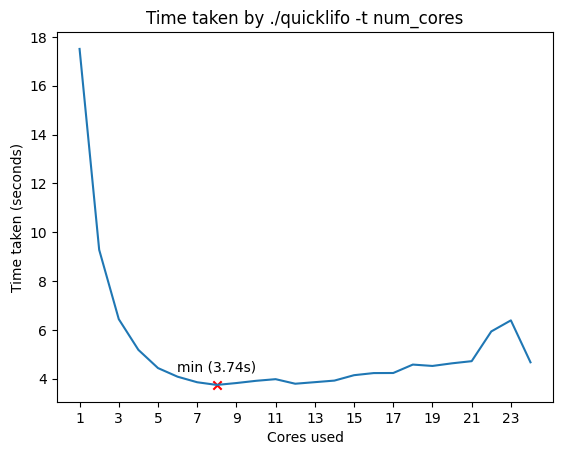

In [21]:
PROC_NAME = "quicklifo"

times = []

print(f"Compiling {PROC_NAME}...")
subprocess.run(["make", f"{PROC_NAME}"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print(f"Running benchmarks for ./{PROC_NAME} -t num_cores -n {size}")
for num_cores in core_values:
    proc = subprocess.run([f"./{PROC_NAME}", "-t", str(num_cores), "-n", str(size)], check=True, capture_output=True)
    output = proc.stdout.decode().strip()
    time_taken = parse_process_output(output)
    print(f"[{str(num_cores).zfill(2)}] Time taken: {time_taken} seconds")
    times.append(time_taken)

min_time = min(times)
min_index = times.index(min_time)

print(f"Minimum time taken: {min_time} seconds for cores = {core_values[min_index]}")

x_ticks = np.arange(min(core_values), max(core_values) + 1, 2)

plt.plot(core_values, times)
plt.scatter(core_values[min_index], min_time, color='red', marker='x')
plt.annotate(f"min ({min_time:.2f}s)", (core_values[min_index], min_time), textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('Cores used')
plt.ylabel('Time taken (seconds)')
plt.title(f'Time taken by ./{PROC_NAME} -t num_cores')
plt.xticks(x_ticks)
plt.show()

quicklifo_times = times.copy()

## Benchmarking Quicksort + Work Stealing scheduler

Compiling quicksteal...
Running benchmarks for ./quicksteal -t num_cores -n 104857600
[01] Time taken: 17.951371 seconds
[02] Time taken: 9.154441 seconds
[03] Time taken: 6.228161 seconds
[04] Time taken: 4.846915 seconds
[05] Time taken: 3.989399 seconds
[06] Time taken: 3.406709 seconds
[07] Time taken: 3.111111 seconds
[08] Time taken: 2.897992 seconds
[09] Time taken: 2.592519 seconds
[10] Time taken: 2.516723 seconds
[11] Time taken: 2.37343 seconds
[12] Time taken: 2.308365 seconds
[13] Time taken: 2.250708 seconds
[14] Time taken: 2.275719 seconds
[15] Time taken: 2.212709 seconds
[16] Time taken: 2.225099 seconds
[17] Time taken: 2.223119 seconds
[18] Time taken: 2.252978 seconds
[19] Time taken: 2.199567 seconds
[20] Time taken: 2.193738 seconds
[21] Time taken: 2.230499 seconds
[22] Time taken: 2.234378 seconds
[23] Time taken: 2.250049 seconds
[24] Time taken: 2.219417 seconds
Minimum time taken: 2.193738 seconds for cores = 20


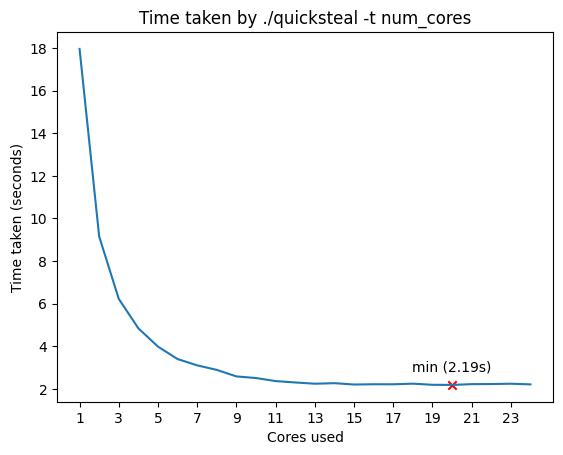

In [22]:
PROC_NAME = "quicksteal"

times = []

print(f"Compiling {PROC_NAME}...")
subprocess.run(["make", f"{PROC_NAME}"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print(f"Running benchmarks for ./{PROC_NAME} -t num_cores -n {size}")
for num_cores in core_values:
    proc = subprocess.run([f"./{PROC_NAME}", "-t", str(num_cores), "-n", str(size)], check=True, capture_output=True)
    output = proc.stdout.decode().strip()
    time_taken = parse_process_output(output)
    print(f"[{str(num_cores).zfill(2)}] Time taken: {time_taken} seconds")
    times.append(time_taken)

min_time = min(times)
min_index = times.index(min_time)

print(f"Minimum time taken: {min_time} seconds for cores = {core_values[min_index]}")

x_ticks = np.arange(min(core_values), max(core_values) + 1, 2)

plt.plot(core_values, times)
plt.scatter(core_values[min_index], min_time, color='red', marker='x')
plt.annotate(f"min ({min_time:.2f}s)", (core_values[min_index], min_time), textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('Cores used')
plt.ylabel('Time taken (seconds)')
plt.title(f'Time taken by ./{PROC_NAME} -t num_cores')
plt.xticks(x_ticks)
plt.show()

quicksteal_times = times.copy()

## Comparaison Graph

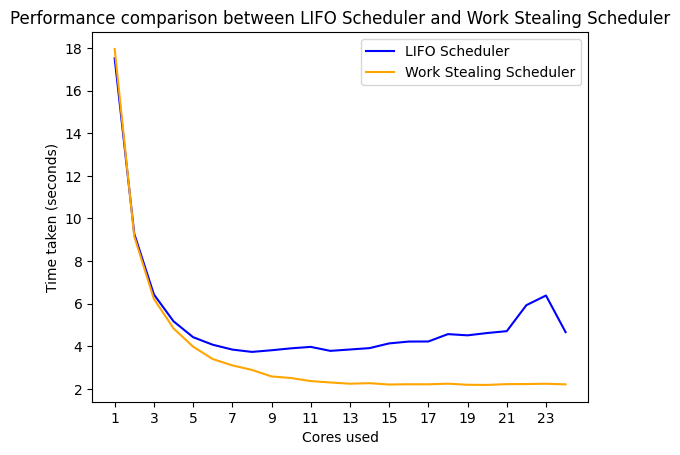

In [23]:
x_ticks = np.arange(min(core_values), max(core_values) + 1, 2)

plt.plot(core_values, quicklifo_times, color='blue', label='LIFO Scheduler')
plt.plot(core_values, quicksteal_times, color='orange', label='Work Stealing Scheduler')

plt.xlabel('Cores used')
plt.ylabel('Time taken (seconds)')
plt.title('Performance comparison between LIFO Scheduler and Work Stealing Scheduler')
plt.xticks(x_ticks)
plt.legend()

plt.show()

## Conclusions

- The Work Stealing Scheduler has better average performance than the LIFO Scheduler

- Adding more cores does not increase performance linearly

- More is not always better. There seems to be an optimum < max_cores in both schedulers (overhead > perfomance gains)

- The first few additionnal cores are extremely important for performance. For example, in both cases, using two cores instead of one cuts computing time by half

## Work Stealing Scheduler Specific Benchmarks

### Data Parsing

In [41]:
def parse_benchmark_data(data):
    lines = data.strip().split('\n')
    success_fail = lines[1].split(',')
    success = int(success_fail[0].split(':')[1].strip())
    fail = int(success_fail[1].split(':')[1].strip())
    
    thread_tasks = {}
    for line in lines[2:-1]:
        parts = line.split('-')
        thread_number = int(parts[0].split()[1]) + 1
        task_count = int(parts[1].split()[0].strip())
        thread_tasks[thread_number] = task_count

    return success, fail, thread_tasks


### Compile and Run

In [47]:
PROC_NAME = "stealbench"

print(f"Compiling {PROC_NAME}...")
subprocess.run(["make", f"{PROC_NAME}"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print(f"Running benchmarks for ./{PROC_NAME} -t 0 (max) -n {size}")
proc = subprocess.run([f"./{PROC_NAME}", "-n", str(size)], check=True, capture_output=True)
output = proc.stdout.decode().strip()
success, fail, thread_tasks = parse_benchmark_data(output)
print(f"Success: {success}, Fail: {fail}")

Compiling stealbench...
Running benchmarks for ./stealbench -t 0 (max) -n 104857600
Success: 33734, Fail: 7595


### Display Task Stealing Steal Success and Failure Rates

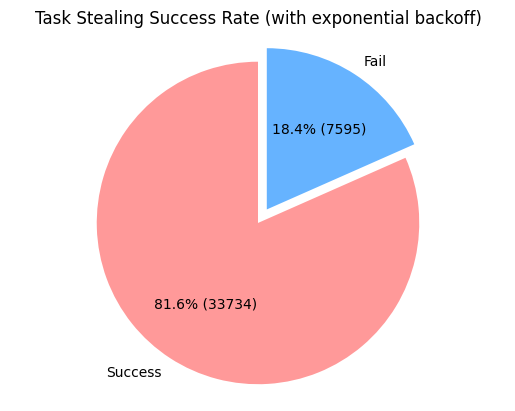

In [48]:
def value_display(val):
    a  = int(round(val/100.*sum(sizes)))
    return f"{val:.1f}% ({a:d})"


labels = 'Success', 'Fail'
sizes = [success, fail]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=value_display, startangle=90)
plt.axis('equal')
plt.title('Task Stealing Success Rate (with exponential backoff)')
plt.show()

## Display Task Distribution Across Threads

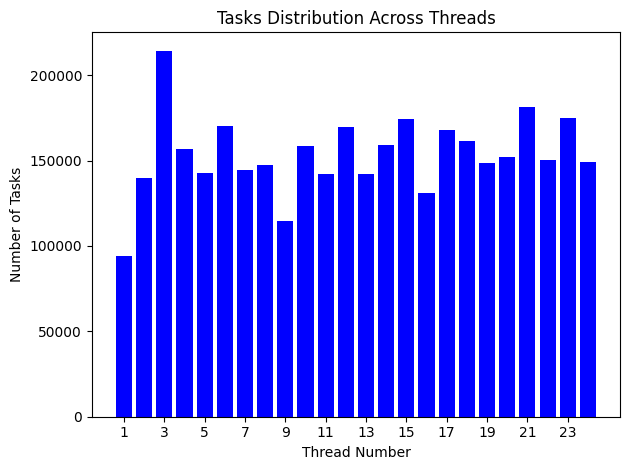

In [49]:
threads = list(thread_tasks.keys())
tasks = list(thread_tasks.values())

x_ticks = np.arange(min(core_values), max(core_values) + 1, 2)

plt.bar(threads, tasks, color='blue')
plt.xlabel('Thread Number')
plt.ylabel('Number of Tasks')
plt.xticks(x_ticks)

plt.title('Tasks Distribution Across Threads')
plt.tight_layout()

plt.show()
